Found 2400 images belonging to 10 classes.
Found 600 images belonging to 10 classes.
87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/10
75/75 [==============================] - 1611s 21s/step - loss: 3.4443 - accuracy: 0.3492 - val_loss: 0.8541 - val_accuracy: 0.8160
Epoch 2/10
75/75 [==============================] - 43s 579ms/step - loss: 0.7849 - accuracy: 0.7342 - val_loss: 0.4127 - val_accuracy: 0.8802
Epoch 3/10
75/75 [==============================] - 44s 583ms/step - loss: 0.5114 - accuracy: 0.8338 - val_loss: 0.1667 - val_accuracy: 0.9583
Epoch 4/10
75/75 [==============================] - 43s 574ms/step - loss: 0.4313 - accuracy: 0.8554 - val_loss: 0.1734 - val_accuracy: 0.9253
Epoch 5/10
75/75 [==============================] - 44s 590ms/step - loss: 0.3118 - accuracy: 0.8921 - val_loss: 0.1186 - val_accuracy: 0.9670
Epoch 6/10
75/75 [==============================] - 42s 566ms/step - loss: 0.2634 - accuracy: 0.8958 - val_loss: 0.1428 - val_accuracy:

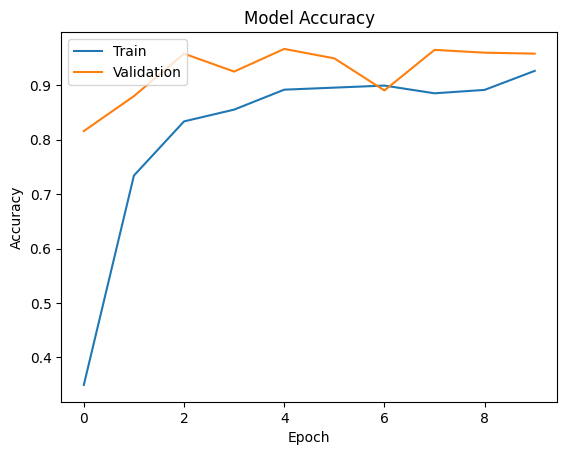

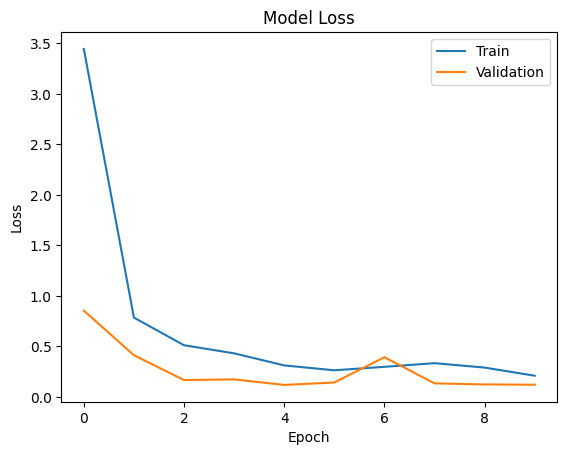

19/19 [==============================] - 7s 305ms/step
Classification Report:
                 precision    recall  f1-score   support

      airplanes       1.00      1.00      1.00        60
    animal bear       0.96      0.92      0.94        60
animal kangaroo       0.96      0.92      0.94        60
            dog       1.00      0.97      0.98        60
       flamingo       1.00      1.00      1.00        60
        gorilla       0.92      0.98      0.95        60
         guitar       1.00      0.98      0.99        60
        leopard       0.95      1.00      0.98        60
           rose       0.82      0.93      0.87        60
      sunflower       0.94      0.85      0.89        60

       accuracy                           0.95       600
      macro avg       0.96      0.95      0.96       600
   weighted avg       0.96      0.95      0.96       600

Confusion Matrix:
[[60  0  0  0  0  0  0  0  0  0]
 [ 0 55  0  0  0  4  0  1  0  0]
 [ 0  1 55  0  0  1  0  1  2  0]
 [ 0

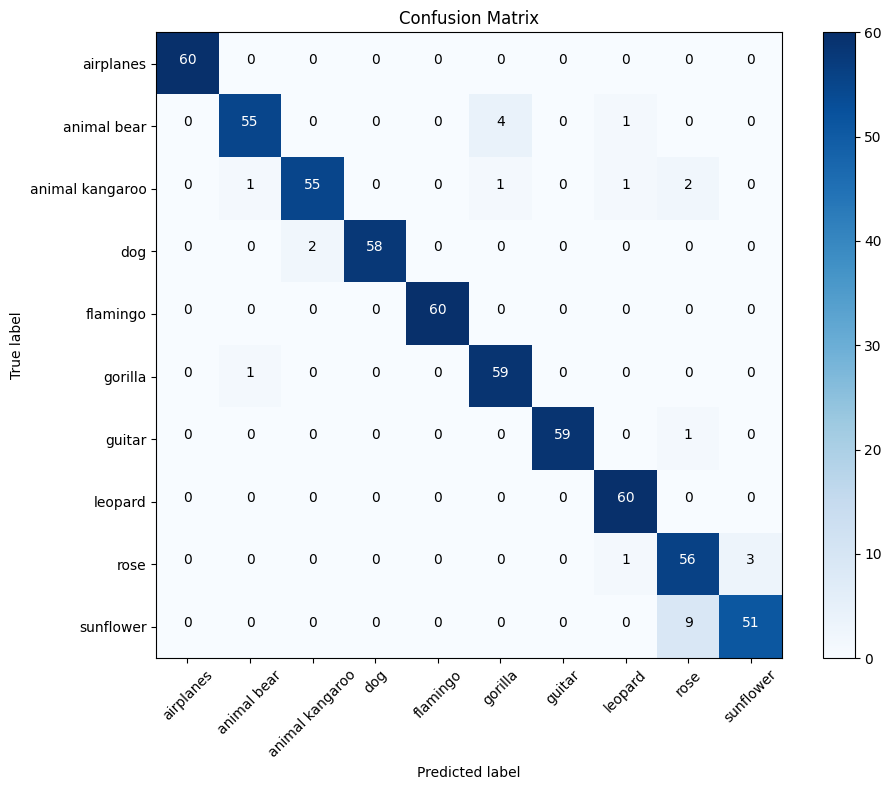

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Define the paths to your train and validation folders
train_path = '/content/drive/MyDrive/vd/240'
val_path = '/content/drive/MyDrive/vd/60'

# Define the image dimensions and number of classes
img_width, img_height = 224, 224
num_classes = 10

# Create data generators for train and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',  # Set class_mode to 'sparse'
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',  # Set class_mode to 'sparse'
    shuffle=False
)

# Load the pre-trained InceptionV3 model
inception = InceptionV3(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False)

# Freeze the layers of InceptionV3
for layer in inception.layers:
    layer.trainable = False

# Add custom top layers for retrieval task
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)  # Update the number of classes to 10

# Create a new model for retrieval
model = Model(inputs=inception.input, outputs=output_layer)

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',  # Update the loss function
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size
)

# Save the trained model
# model.save('image_retrieval_model.h5')

# Generate graphs for accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Generate classification report and confusion matrix
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

class_labels = list(val_generator.class_indices.keys())

classification_rep = classification_report(y_true, y_pred, target_names=class_labels)
confusion_mat = confusion_matrix(y_true, y_pred)

print("Classification Report:")
print(classification_rep)

print("Confusion Matrix:")
print(confusion_mat)

# Visualize confusion matrix as a colorful graph
plt.figure(figsize=(10, 8))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

fmt = 'd'
thresh = confusion_mat.max() / 2.
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, format(confusion_mat[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()
